### KUDAGO categories relation
Goal - to estimate relations between different kudago categories.

to do: 


In [1]:
#connection to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#read dataset
import pandas as pd
DATA0 = pd.read_csv("/content/drive/My Drive/Multi-scale events detection/kudago/403-497_clean.csv", delimiter=';', encoding='cp1251', error_bad_lines=False)
DATA1 = pd.read_csv("/content/drive/My Drive/Multi-scale events detection/kudago/1-402_clean.csv", delimiter=';', encoding='cp1251', error_bad_lines=False)
DATA2 = pd.read_csv("/content/drive/My Drive/Multi-scale events detection/kudago/497-1653_clean.csv", delimiter=';', encoding='cp1251', error_bad_lines=False)
DATA = pd.concat([DATA0,DATA1,DATA2])

In [3]:
print('Event amount', DATA.shape[0])

Event amount 165565


## First step: analyzing event tags

# Preprocessing

In [4]:
#cut the table
df = DATA[['Category', 'Event tag']]

In [5]:
#checking what kind of categories we have
df.groupby(['Category']).count()


,Event tag
Category,
business-events,476
"business-events,entertainment",6
"business-events,festival",17
"business-events,festival,entertainment",1
"business-events,festival,recreation",1
...,...
"tour,recreation,entertainment",5
"tour,yarmarki-razvlecheniya-yarmarki,entertainment",3
yarmarki-razvlecheniya-yarmarki,5


Firstly, let's not use events of multiple categories


In [6]:
#checking how many events we have for each category
df_new = df[~df['Category'].str.contains(',', na=False)]
df_new.groupby(['Category']).count()

,Event tag
Category,
business-events,476
cinema,106
concert,56347
education,10641
entertainment,2625
exhibition,15125
fashion,125
festival,4040
holiday,835


In [30]:
#concatenation of all tags for each category
df_grouped = df_new.groupby(['Category']).apply(lambda x: ','.join(x['Event tag']))

In [31]:
#here we remove categories of kudago, which we will not use for events detecting task 
df_grouped = df_grouped.drop(['quest', 'yarmarki-razvlecheniya-yarmarki','other'], axis=0)
df_grouped

Category
business-events    12+,события для бизнеса,события для бизнеса,со...
cinema             кинопоказы,12+,кино (развлечения),кино (развле...
concert            рэп и хип-хоп,концерты,16+,концерты,альтернати...
education          обучение,16+,лучшее,искусство,обучение,12+,рис...
entertainment      игры,развлечения,16+,шоу,лучшее в театрах,разв...
exhibition         выставки,картины, живопись, графика,выставки,к...
fashion            мода и стиль,шоурумы,красота и здоровье,тренин...
festival           фестивали,городские,free,культура и искусство,...
holiday            животные,тематические праздники,выходные,празд...
kids               12+,детские лагеря,лучшее в мае,детям,детские ...
party              18+,танцевальная,вечеринки,электронная музыка,...
photo              животные,фотография,интересное,всей семьей,fre...
recreation         отдых,18+,спорт и фитнес,хоккей,6+,отдых,отдых...
shopping           шопинг (магазины),free,шопинг (магазины),книги...
social-activity    благот

In [33]:
#the next cell is very time expensive, we check if we have a file with it
import os
check_file = False
if os.path.exists('/content/drive/My Drive/Colab Notebooks/kudago_tags.pkl'):
  check_file = True
  df_final = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/kudago_tags.pkl')
check_file

True

In [38]:
#We want to know which tags (rows) were used for which categories (columns) and how many times (data in cells)
#To do it we create DataFrame from the dict of subdicts: one subdict for one category, each subdict maps tag to number of tag's usages 
if check_file == False:
  dict_lists = dict()
  for index in df_grouped.index:
    temp = df_grouped.get(index).rsplit(',')
    one_dict = {i:temp.count(i) for i in temp}
    dict_lists[index]=(one_dict)
  #final statistics DataFrame
  df_final = pd.DataFrame(dict_lists).fillna(0)
else:
  print('File was found')

File was found


In [39]:
df_final

,business-events,cinema,concert,education,entertainment,exhibition,fashion,festival,holiday,kids,party,photo,recreation,shopping,social-activity,stock,theater,tour
12+,12.0,10.0,10786.0,1526.0,207.0,971.0,4.0,283.0,15.0,36.0,22.0,1.0,210.0,0.0,3.0,663.0,3661.0,602.0
события для бизнеса,476.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18+,167.0,67.0,14700.0,1932.0,556.0,401.0,11.0,427.0,39.0,0.0,3527.0,3.0,176.0,0.0,19.0,3497.0,1978.0,150.0
free,135.0,29.0,2594.0,2681.0,356.0,4051.0,29.0,1653.0,315.0,122.0,1177.0,12.0,348.0,42.0,81.0,168.0,435.0,164.0
16+,70.0,11.0,11108.0,2094.0,286.0,454.0,14.0,303.0,9.0,0.0,123.0,0.0,128.0,4.0,7.0,908.0,5364.0,102.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
погода,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
эзотерика,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
блошиные рынки,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
ярмарки (развлечения,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
#save dataframe to file
if check_file == False:
  df_final.to_pickle("/content/drive/My Drive/Colab Notebooks/kudago_tags.pkl")
else:
  print('File exists')

File exists


In [23]:
!pip install supervenn

In [41]:
#labels are categories
labels = list(df_final.columns)
#sets are tags
sets = []
for index in df_grouped.index:
  temp = df_grouped.get(index).rsplit(',')
  sets.append(set(temp))

In [42]:
#to find intersections of categories we don't consider unique tags
new_sets = []
for i in range(len(sets)):
  temp_list = []
  for j in range(len(sets)):
    #avoiding comparing with the same set
    if i == j:
      continue
    #we collect not unique tags into list
    temp_list.extend(sets[i] & sets[j])
  #now we need to convert our collection to set
  new_sets.append(set(temp_list))

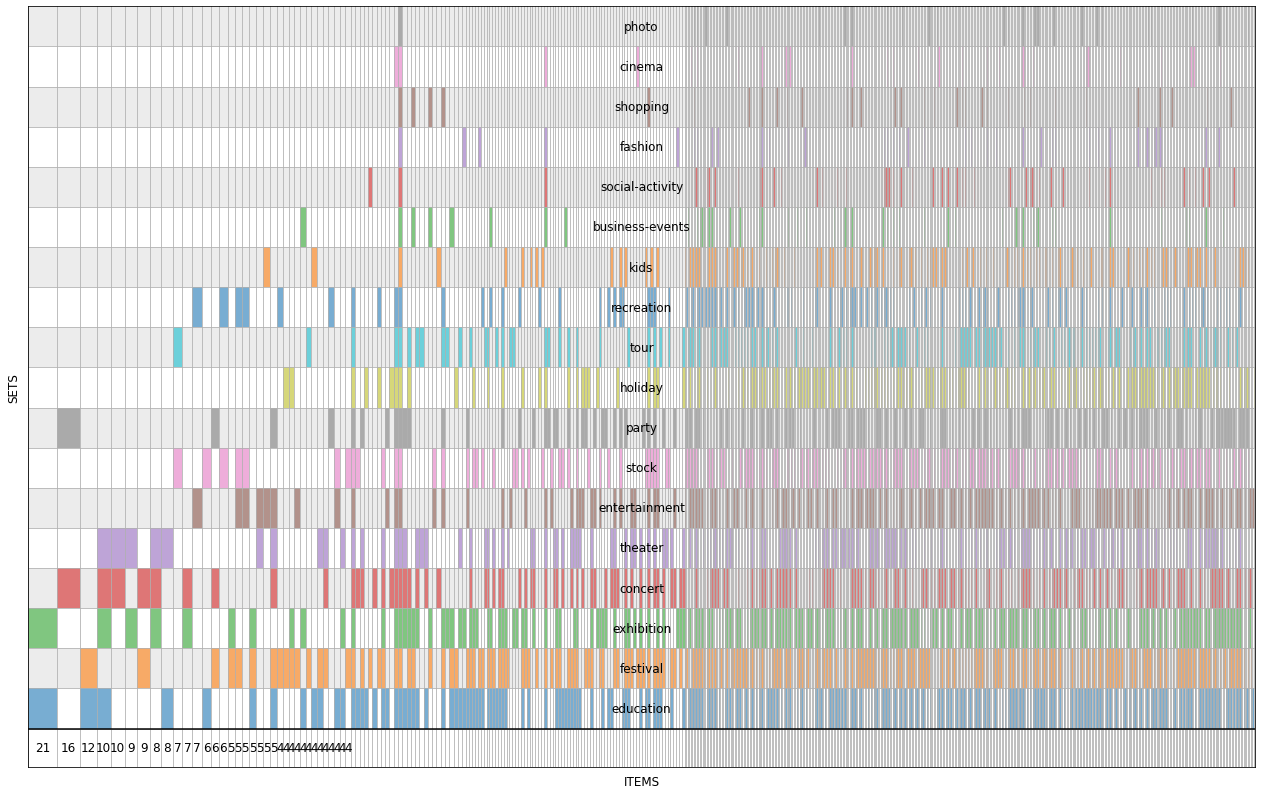

In [43]:
#visualize data with method from https://habr.com/ru/company/yandex/blog/501924/
import matplotlib.pyplot as plt
from supervenn import supervenn
plt.figure(figsize=(22, 14))
supervenn(new_sets, labels, side_plots=False, chunks_ordering='size', sets_ordering='size', widths_minmax_ratio=0.05, min_width_for_annotation=4)

Results are good, but not so clean, let's delete very frequent tags

In [44]:
#here we check in how many categories the particular tag appears, and delete very frequent tags
import copy
new_sets_cut = copy.deepcopy(new_sets)

#for all sets
for i in range(len(new_sets)):
  #check all tags
  for j in new_sets[i]:
    counter = 0
    #check for all other sets except the same one
    for k in range(len(new_sets)):
      if k == i:
        continue
      if j in new_sets[k]:
        counter += 1
    if counter > 5:
      new_sets_cut[i].remove(j)

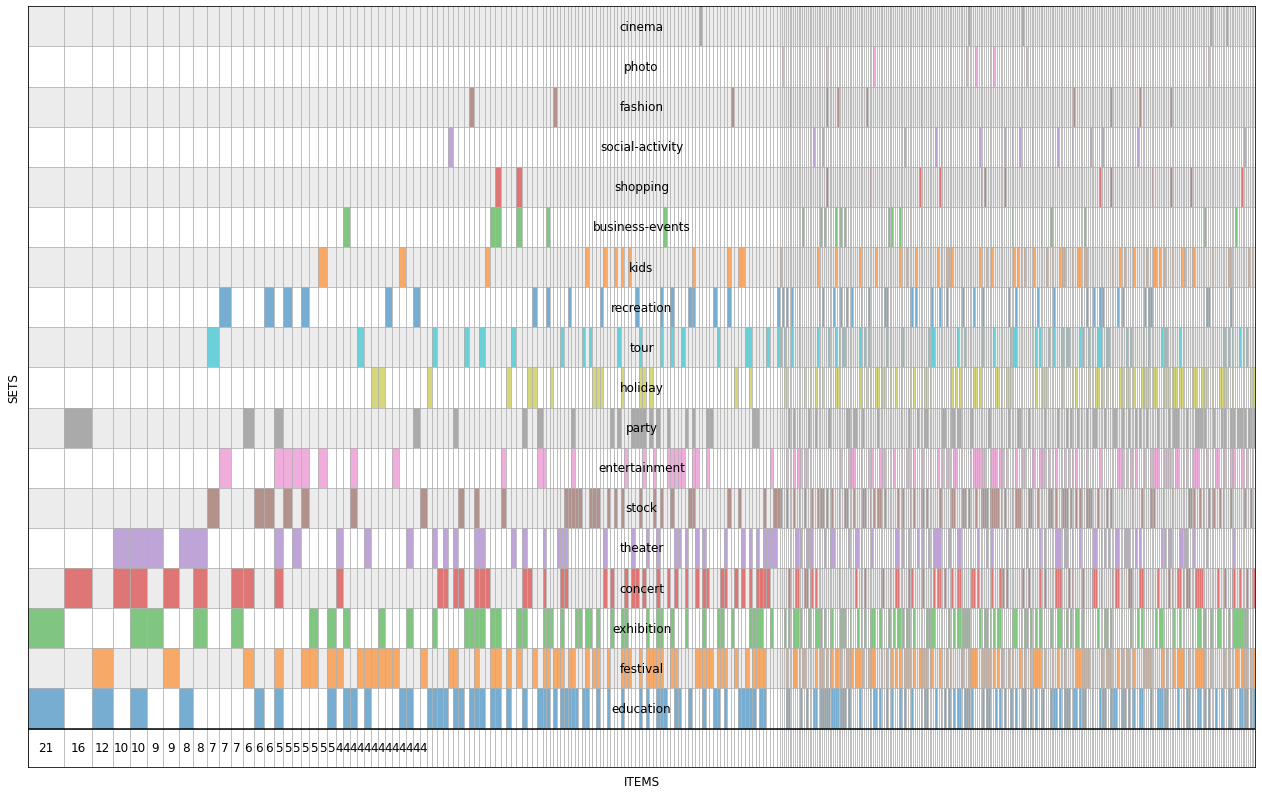

In [45]:
plt.figure(figsize=(22, 14))
supervenn(new_sets_cut, labels, side_plots=False, chunks_ordering='size', sets_ordering='size', widths_minmax_ratio=0.05, min_width_for_annotation=4)